In [ ]:
import numpy as np              # Массивы (матрицы, векторы, линейная алгебра)
import matplotlib.pyplot as plt # Научная графика
%matplotlib inline 
    # Говорим jupyter'у, чтобы весь графический вывод был в браузере, а не в отдельном окне
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

# Прогноз погоды на завтра в австралии

Предположим, что вы находитесь в Австралии и хотите узнать, будет ли завтра дождь.

## Загружаем данные

In [ ]:
url = "https://raw.githubusercontent.com/stasyurin/machine_learning_2021/master/Classification_task/data/weatherAUS.csv"
data = pd.read_csv(url)

Таблица содержит данные о ежедневных наблюденях за погодой из многих мест по всей Австралии на протяжении 10 лет.

Размеры таблицы:

In [ ]:
data.shape

(145460, 23)

In [ ]:
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Мы видим, что столбцы (признаки) имеют имена

- `Date` - Дата наблюдения
- `Location` - Общее название места расположения метеостанции
- `MinTemp` - Минимальная температура в градусах Цельсия в этот день
- `MaxTemp` - Максимальная температура в градусах Цельсия в этот день
- `Rainfall` - Количество осадков, выпавших за сутки в мм.
- `Evaporation` - Так называемое испарение из эвапорометра класса А (мм) за 24 часа до 9 утра. (*Эвапорометр - устройство измерения общего испарения при одновременном воздействии разных текущих климатических факторов, таких как: температура, влажность, атмосферные осадки, солнечная радиация, ветер*)
- `Sunshine` - Количество часов яркого солнечного света в сутки.
- `WindGustDir` - Направление самого сильного порыва ветра за 24 часа до полуночи
- `WindGustSpeed` - Скорость (км/ч) самого сильного порыва ветра за 24 часа до полуночи
- `WindDir9am` - Направление ветра в 9 утра
- `WindDir3pm` - Направление ветра в 15:00
- `WindSpeed9am` - Средняя скорость ветра (км/ч) за 10 минут до 9:00
- `WindSpeed3pm` - Средняя скорость ветра (км/ч) за 10 минут до 15:00
- `Humidity9am` - Влажность (в процентах) в 9 утра
- `Humidity3pm` - Влажность (в процентах) в 15:00
- `Pressure9am` - Атмосферное давление (гПа) на уровне среднего уровня моря в 9:00.
- `Pressure3pm` - Атмосферное давление (гПа) на уровне среднего уровня моря в 15:00.
- `Cloud9am` - Площадь неба, закрытая облаками в 9 утра. Измеряется в «октах» (часть от восьми). Показатель фиксирует, сколько восьмых неба закрыто облаками. Значение 0 указывает на абсолютно ясное небо, а значение 8 указывает на полную облачность.
- `Cloud3pm` - Площадь неба, закрытая облаками в 15:00
- `Temp9am` - Температура в градусах Цельсия в 9 утра
- `Temp3pm` - Температура в градусах Цельсия в 15:00
- `RainToday` - Булево значение: 1, если осадки (мм) за 24 часа до 9:00 превышают 1 мм, в противном случае 0
- `RainTomorrow` - Количество осадков на следующий день в мм. Используется для создания переменной ответа RainTomorrow. Своего рода мера «риска».

Признаки `RainToday` и `RainTomorrow` - бинарный, признаки `Location`, `WindGustDir`, `WindDir9am`, `WindDir3pm` - номинальные (категориальные), `Date` имеет тип дата, остальные признаки - количественные (числовые).

Требуется предсказать бинарный признак `RainTomorrow` по остальным признакам. Это *задача классификации*.

## Готовим данные

Приведем столбец `Date` к числовому типу

In [ ]:
from datetime import datetime, timedelta
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].sub(datetime(2008, 12, 1), axis=0).dt.days
data['Date']

0            0
1            1
2            2
3            3
4            4
          ... 
145455    3124
145456    3125
145457    3126
145458    3127
145459    3128
Name: Date, Length: 145460, dtype: int64

In [ ]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


## Боремся с выбросами (outliers)

In [ ]:
rows_to_drop = []
for column in data.columns:
    if (column in categorical_columns):
        continue
    rows_to_drop += data[(data[column] < data[column].quantile(0.005))
    | (data[column] > data[column].quantile(0.995))].index.tolist()
data = data.drop(rows_to_drop)
data.shape

(135248, 23)

Для всех количественных признаков удаление выбросов привело к сокращению количества строк на 145460 - 136606 = 8854 строк

## Визуализация и описательная статистика

Матрица корреляции

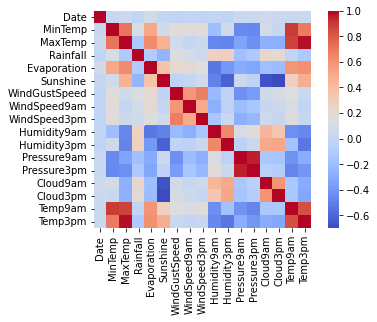

In [ ]:
corr_mat = data.corr()
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

### Интерпретация
- Как видим минимальная температура `MinTemp` достаточно сильно коррелирует с максимальной MaxTemp, что очевидно, так как в жарком дне в среднем и минимальная и максимальная температура будут выше, а в холодном - ниже
- Также `MinTemp` и `MaxTemp` коррелируют с Temp9am и Temp3pm, что так же очевидно
- `Rainfall` слабо коререлирует с какими либо другими признаками. Наибольшая корреляция с `Humidity9am` и `Humidity3pm` (что очевидно - чем больше осадков, тем сильнее влажность), и с `Cloud9am` и `Cloud3pm` (чем облачнее, тем больше вероятность, что пойдет дождь)
- `Evaporation` (количество испарения из эвапорометра) коррелирует со всеми признаками связанными с температурой - чем выше температура, тем интенсивнее жидкость испаряется
- `Sunshine` так же коррелирует с признаками связанными с температурой - чем больше солнца, тем выше температура
- Признаки скорости ветра коррелируют только между собой, что очевидно так как ни от температуры, ни от давления, ни от других признаков они не зависят
- Коррелируют Humidity и Cloud - признаки влажности и облачности, что также связано с выпадением осадков
- И корреляция признаков, показывающих давление с другими признаками так же слабая

In [ ]:
data.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,135248.000000,133844.000000,134057.000000,132172.000000,76874.000000,70268.000000,125675.000000,133608.000000,132377.000000,132882.000000,131091.000000,121577.000000,121618.000000,83296.000000,80116.000000,133674.000000,131947.000000
mean,1586.294215,12.223570,23.242705,1.917812,5.230514,7.629323,39.426035,13.776780,18.473572,69.106937,51.512819,1017.831621,1015.440893,4.450898,4.497416,17.004615,21.705487
std,910.609749,6.130843,6.662336,5.519462,3.383338,3.747351,12.540924,8.472699,8.391994,18.085148,20.048206,6.657136,6.593576,2.877375,2.716197,6.104716,6.501285
min,-112.000000,-3.100000,5.400000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,14.000000,7.000000,997.500000,996.100000,0.000000,0.000000,0.900000,4.400000
25%,777.000000,7.700000,18.200000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1013.300000,1010.800000,1.000000,2.000000,12.400000,16.800000
50%,1640.000000,12.000000,22.700000,0.000000,4.600000,8.500000,37.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.700000,21.200000
75%,2378.000000,16.700000,28.100000,0.600000,7.200000,10.600000,46.000000,19.000000,24.000000,83.000000,65.000000,1022.400000,1020.000000,7.000000,7.000000,21.400000,26.300000
max,3114.000000,26.500000,41.600000,53.000000,23.000000,13.600000,87.000000,44.000000,46.000000,100.000000,99.000000,1035.500000,1033.000000,8.000000,8.000000,32.400000,39.900000


##  Обрабатываем пропущенные значения

В данных присутствуют пропущенные значения:

In [ ]:
data.isna().sum()

Date                 0
Location             0
MinTemp           1404
MaxTemp           1191
Rainfall          3076
Evaporation      58374
Sunshine         64980
WindGustDir       9633
WindGustSpeed     9573
WindDir9am        9717
WindDir3pm        3900
WindSpeed9am      1640
WindSpeed3pm      2871
Humidity9am       2366
Humidity3pm       4157
Pressure9am      13671
Pressure3pm      13630
Cloud9am         51952
Cloud3pm         55132
Temp9am           1574
Temp3pm           3301
RainToday         3076
RainTomorrow      3051
dtype: int64

Заполним медианами пропущенные значения в столбцах, соответствующих числовым признакам:

In [ ]:
data.fillna(data.median(axis = 0), axis=0 , inplace=True)

In [ ]:
data.isna().sum()

Date                0
Location            0
MinTemp             0
MaxTemp             0
Rainfall            0
Evaporation         0
Sunshine            0
WindGustDir      9633
WindGustSpeed       0
WindDir9am       9717
WindDir3pm       3900
WindSpeed9am        0
WindSpeed3pm        0
Humidity9am         0
Humidity3pm         0
Pressure9am         0
Pressure3pm         0
Cloud9am            0
Cloud3pm            0
Temp9am             0
Temp3pm             0
RainToday        3076
RainTomorrow     3051
dtype: int64

Пропущенные значения в столбцах, соответствующих категориальным признакам, заполним модой:

In [ ]:
for c in categorical_columns:
    data[c].fillna(data[c].mode().iloc[0], inplace=True)

In [ ]:
data.isna().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

## Векторизация

Обработка категориальных признаков

In [ ]:
data_describe = data.describe(include = [object])
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['RainToday', 'RainTomorrow'] ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']


In [ ]:
data['RainToday'].unique()

array(['No', 'Yes'], dtype=object)

In [ ]:
data.at[data['RainToday'] == 'No', 'RainToday'] = 0
data.at[data['RainToday'] == 'Yes', 'RainToday'] = 1
data['RainToday'].describe()

count     135248
unique         2
top            0
freq      106291
Name: RainToday, dtype: int64

К небинарными признакам применим метод _векторизации_, 
который заключается в следующем.

Признак `j`, принимающий `s` значений, заменим на `s` признаков, принимащих значения `0` или `1`,
в зависимости от того, чему равно значение исходного признака `j`.

In [ ]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Location_Adelaide', 'Location_Albany', 'Location_Albury',
       'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat',
       'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns',
       'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour',
       'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast',
       'Location_Hobart', 'Location_Katherine', 'Location_Launceston',
       'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura',
       'Location_Moree', 'Location_MountGambier', 'Location_MountGinini',
       'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead',
       'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF',
       'Location_Penrith', 'Location_Perth', 'Location_PerthAirport',
       'Location_Portland', 'Location_Richmond', 'Location_Sale',
       'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport',
       'Location_Townsville', 'Location_Tuggeranong', 'Location_Ulur

## Нормализация количественных признаков

Многие алгоритмы машинного обучения чувствительны к масштабированию данных.
К таким алгоритмам, например, относится метод ближайших соседей, машина опорных векторов и др.

В этом случае количественные признаки полезно _нормализовать_.
Это можно делать разными способами.
Например, каждый количественный признак приведем к нулевому среднему и единичному среднеквадратичному отклонению:

In [ ]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000,135248.000000
mean,1586.294215,12.221249,23.237926,1.874194,4.958379,8.047641,39.254318,13.767361,18.484747,69.122560,51.527793,1017.828425,1015.436772,4.661821,4.702288,17.001070,21.693150
std,910.609749,6.098980,6.633131,5.463821,2.569800,2.735877,12.104946,8.421602,8.302791,17.926642,19.737876,6.311724,6.252521,2.273834,2.105058,6.069176,6.421929
min,-112.000000,-3.100000,5.400000,0.000000,0.200000,0.000000,13.000000,0.000000,0.000000,14.000000,7.000000,997.500000,996.100000,0.000000,0.000000,0.900000,4.400000
25%,777.000000,7.800000,18.200000,0.000000,4.000000,8.300000,31.000000,7.000000,13.000000,58.000000,38.000000,1013.800000,1011.400000,3.000000,4.000000,12.500000,16.900000
50%,1640.000000,12.000000,22.700000,0.000000,4.600000,8.500000,37.000000,13.000000,19.000000,70.000000,52.000000,1017.800000,1015.400000,5.000000,5.000000,16.700000,21.200000
75%,2378.000000,16.700000,28.000000,0.600000,5.200000,8.700000,46.000000,19.000000,24.000000,82.000000,65.000000,1021.800000,1019.400000,6.000000,6.000000,21.300000,26.100000
max,3114.000000,26.500000,41.600000,53.000000,23.000000,13.600000,87.000000,44.000000,46.000000,100.000000,99.000000,1035.500000,1033.000000,8.000000,8.000000,32.400000,39.900000


In [ ]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05,1.352480e+05
mean,2.100959e-16,2.364322e-14,-2.211592e-14,-2.547673e-14,1.463751e-12,1.000104e-13,2.470284e-14,2.441189e-14,-2.003028e-14,4.437779e-15,3.056318e-15,1.866539e-11,-2.190356e-11,2.200904e-14,-8.242794e-15,3.188228e-14,-2.212244e-13
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.865008e+00,-2.512100e+00,-2.689217e+00,-3.430189e-01,-1.851654e+00,-2.941521e+00,-2.168892e+00,-1.634767e+00,-2.226329e+00,-3.074896e+00,-2.255957e+00,-3.220740e+00,-3.092636e+00,-2.050203e+00,-2.233805e+00,-2.652925e+00,-2.692828e+00
25%,-8.887388e-01,-7.249161e-01,-7.595095e-01,-3.430189e-01,-3.729393e-01,9.224075e-02,-6.818963e-01,-8.035717e-01,-6.605907e-01,-6.204486e-01,-6.853723e-01,-6.382447e-01,-6.456231e-01,-7.308455e-01,-3.336192e-01,-7.416278e-01,-7.463722e-01
50%,5.897783e-02,-3.627641e-02,-8.109683e-02,-3.430189e-01,-1.394581e-01,1.653434e-01,-1.862311e-01,-9.111814e-02,6.205786e-02,4.894614e-02,2.392388e-02,-4.503495e-03,-5.881139e-03,1.487262e-01,1.414272e-01,-4.960638e-02,-7.679151e-02
75%,8.694238e-01,7.343442e-01,7.179225e-01,-2.332057e-01,9.402312e-02,2.384461e-01,5.572666e-01,6.213354e-01,6.642650e-01,7.183409e-01,6.825561e-01,6.292377e-01,6.338608e-01,5.885121e-01,6.164736e-01,7.083218e-01,6.862191e-01
max,1.677673e+00,2.341170e+00,2.768236e+00,9.357152e+00,7.020633e+00,2.029462e+00,3.944312e+00,3.589892e+00,3.313976e+00,1.722433e+00,2.405133e+00,2.799801e+00,2.808983e+00,1.468084e+00,1.566566e+00,2.537236e+00,2.835106e+00


## Соединяем все в одну таблицу

In [ ]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(135248, 116)


## 7. Разбиение данных на обучающую и тестовую выборки

Для предсказания будем использовать все признаки.

In [ ]:
X = data.drop('RainTomorrow', axis = 1)
y = data['RainTomorrow']

Разобьем данные на обучающую и тестовую выборки в пропорции 3:1 (75% - обучающая выборка, 25% - тестовая):

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

N_train, N_test

(101436, 33812)

## Классификатор ближайших соседей

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)

In [ ]:
err_train

0.09763791947632004

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)

In [ ]:
err_test

0.170708624157104

Ошибка на обучающей выборке меньше из-за так называемого переобучения. На определенных данных алгоритм улавливает какие-то случайные закономерности, свойственные только конкретному набору данных, и используя их, ошибается меньше.

Матрица рассогласования:

In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_test_predict))

[[24608  1900]
 [ 3872  3432]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


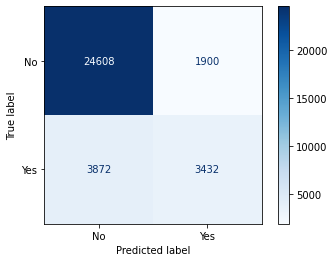

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(knn, X_test, y_test, cmap=plt.cm.Blues)
pass

Тру негативов больше чем тру позитивов, из-за несбалансированности классов. В `RainTomorrow` No составляет 78%, Yes - 22%

### Увеличим количество ближайших соседей до 9

In [ ]:
knn.set_params(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.13012145589337118

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.15574352300958239

### Увеличим количество ближайших соседей до 17

In [ ]:
knn.set_params(n_neighbors=17)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=17)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.13906305453685083

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.15352537560629362

### Увеличим количество ближайших соседей до 51

In [ ]:
knn.set_params(n_neighbors=51)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=51)

In [ ]:
y_train_predict = knn.predict(X_train)
err_train  = np.mean(y_train  != y_train_predict)
err_train

0.1486257344532513

In [ ]:
y_test_predict = knn.predict(X_test)
err_test  = np.mean(y_test  != y_test_predict)
err_test

0.15580267360700342

### Подбор параметров

In [ ]:
# Долго!
from sklearn.model_selection import GridSearchCV
nnb = [1, 3, 5, 9, 15, 19, 25, 35, 45, 55]
knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.15153394588302116 19


Наиболее эффективен метод с 19-ю ближайшими соседями, хотя вероятности для разного числа соседей на тестовой выборке примерно одинаковы.